# TM10007 Assignment template

In [1]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [26]:
#Load packages

import pandas as pd
import numpy as np
import matplotlib.pyplot

#from sklearn.decomposition import PCA
#from sklearn import datasets as ds
from sklearn import metrics
from sklearn import model_selection
from sklearn.manifold import TSNE



# Classifiers 
# from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier


# Importing Data loading functions. Uncomment the one you want to use
from worcliver.load_data import load_data

from scipy.stats import ttest_ind, mannwhitneyu, shapiro
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from scipy.stats import zscore
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score


#import scalers 
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler


In [27]:
# Loading the data
data = load_data()

# Presentation of the data:

In [3]:
# Description of the data
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Display basic info
print("First five rows of the dataset:")
print(data.head(), "\n")

print("Dataset info:")
print(data.info(), "\n")

print("Summary statistics:")
print(data.describe(), "\n")

# Counting missing values
missing_values = data.isnull().sum()
total_missing = missing_values.sum()

print(f"Total missing values in the dataset: {total_missing}\n")
print(f"Missing values per column:\n{missing_values[missing_values > 0]}\n")

# Counting categorical and numerical columns
categorical_columns = data.select_dtypes(include=['object']).columns
numerical_columns = data.select_dtypes(exclude=['object']).columns

print(f"Number of categorical columns: {len(categorical_columns)}")
print(f"Number of numerical columns: {len(numerical_columns)}\n")

# Count of each label (benign/malignant)
label_counts = data['label'].value_counts()

print("Label distribution:")
print(label_counts)


The number of samples: 186
The number of columns: 494
First five rows of the dataset:
                 label  PREDICT_original_sf_compactness_avg_2.5D  \
ID                                                                 
Liver-001_0     benign                                  0.878471   
Liver-002_0     benign                                  0.878945   
Liver-003_0     benign                                  0.766162   
Liver-004_0  malignant                                  0.825737   
Liver-005_0  malignant                                  0.828831   

             PREDICT_original_sf_compactness_std_2.5D  \
ID                                                      
Liver-001_0                                  0.023468   
Liver-002_0                                  0.039922   
Liver-003_0                                  0.064140   
Liver-004_0                                  0.062047   
Liver-005_0                                  0.062635   

             PREDICT_original_sf_rad_

# Visualization of features

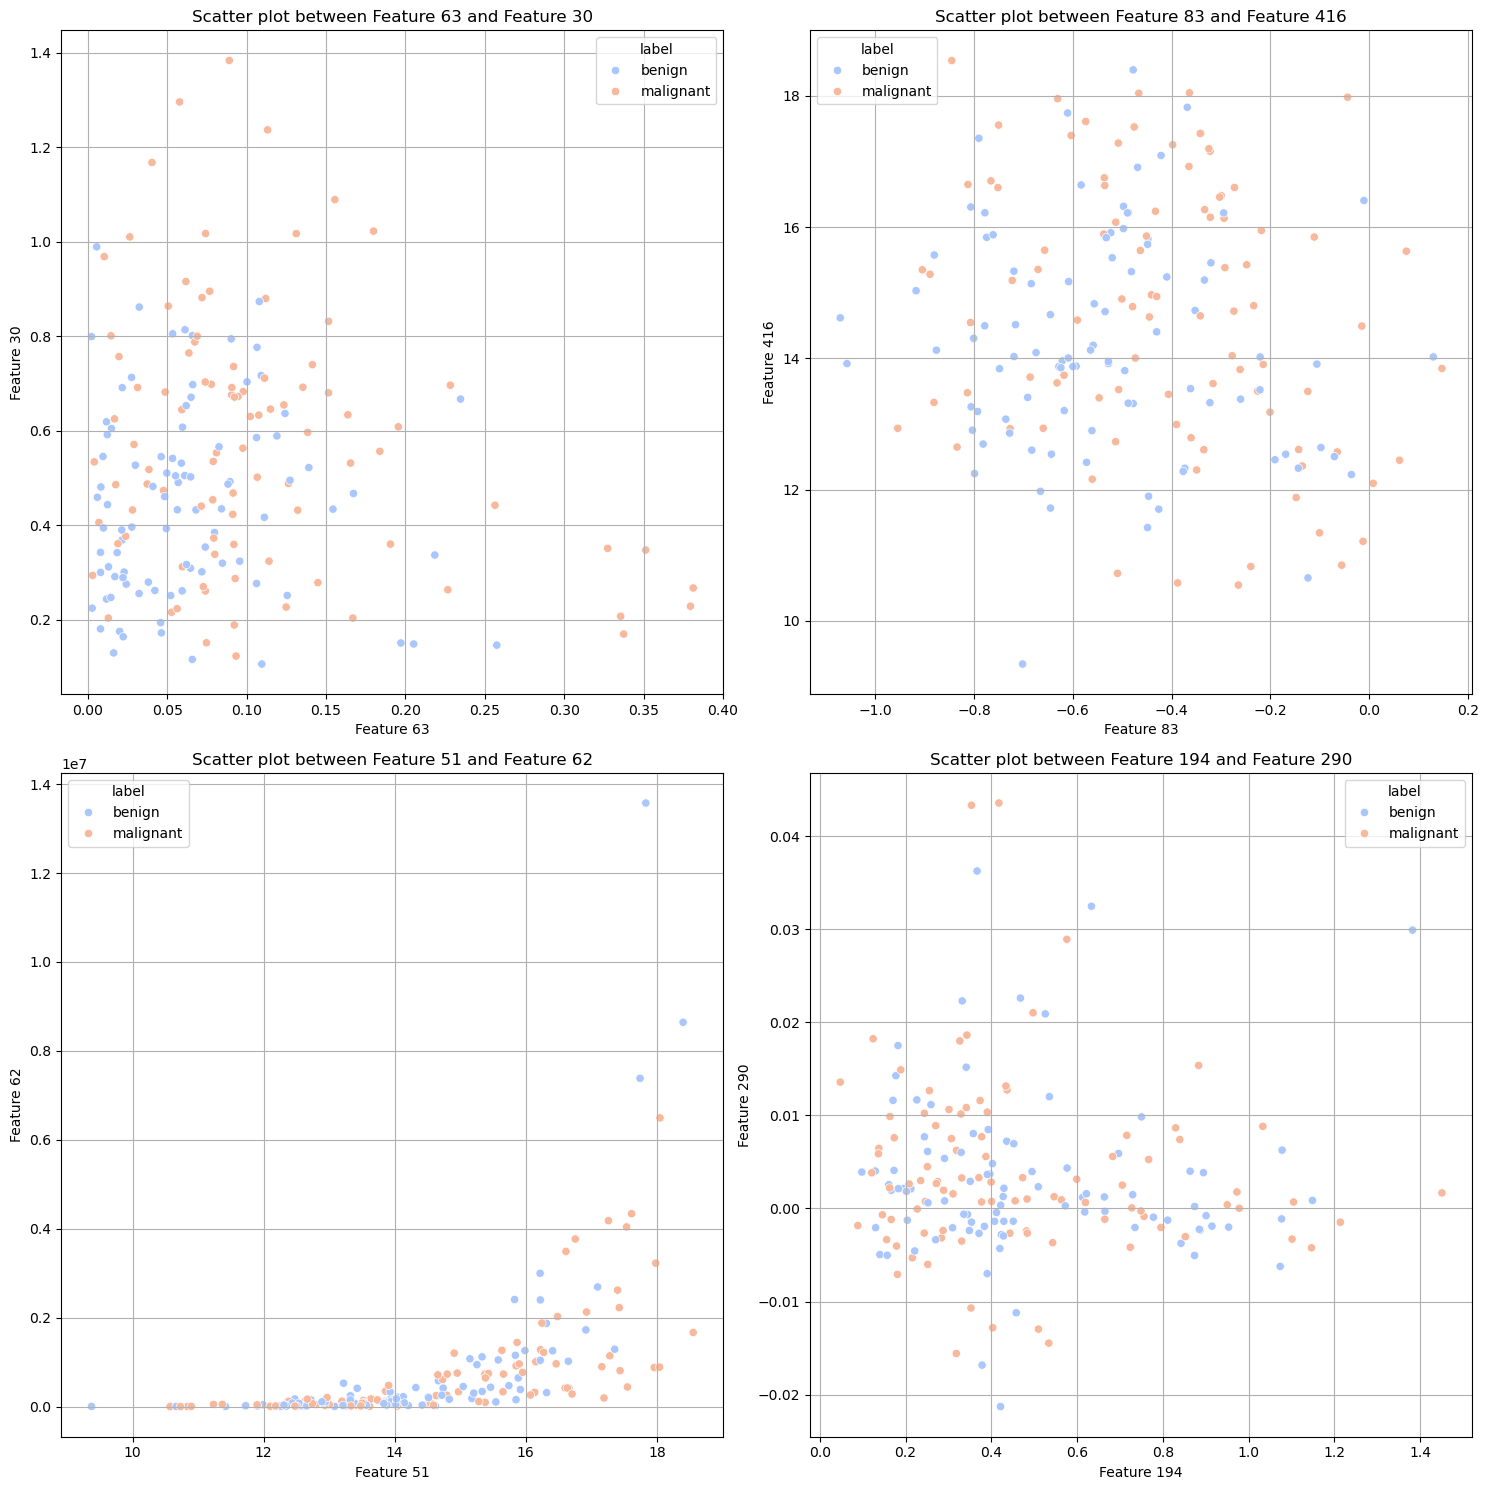

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# For loop with a 4 subplots in which 2 features are put against eachother to visualize the data
fig = plt.figure(figsize=(15, 15))

for i in range(4):
    random_columns = np.random.choice(data.columns[:-1], size=2, replace=False)
    
    # Use the index number of the feature for the title
    feature_num1 = list(data.columns).index(random_columns[0]) + 1  # Adding 1 to make it human-readable (starting from 1)
    feature_num2 = list(data.columns).index(random_columns[1]) + 1  # Adding 1 to make it human-readable (starting from 1)
    
    ax = fig.add_subplot(2, 2, i + 1)  # Manually creating subplots (2 rows, 2 columns)
    sns.scatterplot(x=data[random_columns[0]], y=data[random_columns[1]], hue=data['label'], palette='coolwarm', ax=ax)
    ax.set_title(f"Scatter plot between Feature {feature_num1} and Feature {feature_num2}")
    ax.set_xlabel(f"Feature {feature_num1}")
    ax.set_ylabel(f"Feature {feature_num2}")
    ax.grid(True)

plt.tight_layout()
plt.show()



# Changing labels malignant and benign to 0 and 1

In [28]:
#changing string (malignant or benign) to 0 or 1
num_data = data.copy()

# Transform labels: benign -> 1, malignant -> 0
num_data['label'] = num_data['label'].map({'benign': 1, 'malignant': 0})

# Splitting data in train and test test


In [29]:
#Splitting data in test and train set 
y = num_data['label']
x = num_data[:]

#x is features, y  = maligne / benign
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

#print the shape of the data sets  
print(f'The shape of the train data: {x_train.shape}')
print(f'The shape of the test data: {x_test.shape}')

x_train.to_csv('x_train.csv', index=False) 
x_test.to_csv('x_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False) 
y_test.to_csv('y_test.csv', index=False)




The shape of the train data: (148, 494)
The shape of the test data: (38, 494)


# Checking for ouliners

In [9]:
# Checking skewness for each feature in the training set in order to choose the scaler
skewness = x_train.skew()

# Printing the skewness for each feature
print("Skewness of features:")
print(skewness)

# Identifying features that have skewness greater than 1 or less than -1 (highly skewed)
skewed_features = skewness[abs(skewness) > 1].index
print("\nHighly skewed features (Skewness > 1 or < -1):")
print(skewed_features)

# Checking for outliers using Z-scores (Threshold: Z > 3 or Z < -3)
z_scores = np.abs(zscore(x_train))

# Identifying features with Z-scores above the threshold (outliers)
outliers = (z_scores > 3)

# Getting the feature names where outliers exist
outlier_features = x_train.columns[(outliers.any(axis=0))].tolist()
print("\nFeatures with outliers (Z-score > 3):")
print(outlier_features)

# Optionally, calculate the IQR for outlier detection
Q1 = x_train.quantile(0.25)
Q3 = x_train.quantile(0.75)
IQR = Q3 - Q1

# Detecting outliers based on IQR
outliers_iqr = ((x_train < (Q1 - 1.5 * IQR)) | (x_train > (Q3 + 1.5 * IQR)))

# Getting feature names with IQR outliers
outlier_features_iqr = x_train.columns[(outliers_iqr.any(axis=0))].tolist()
print("\nFeatures with outliers based on IQR:")
print(outlier_features_iqr)

Skewness of features:
label                                                     0.027307
PREDICT_original_sf_compactness_avg_2.5D                 -1.336697
PREDICT_original_sf_compactness_std_2.5D                  1.755783
PREDICT_original_sf_rad_dist_avg_2.5D                     0.896949
PREDICT_original_sf_rad_dist_std_2.5D                     1.521164
                                                            ...   
PREDICT_original_phasef_phasesym_peak_position_WL3_N5     0.000000
PREDICT_original_phasef_phasesym_range_WL3_N5            -0.879185
PREDICT_original_phasef_phasesym_energy_WL3_N5            2.949009
PREDICT_original_phasef_phasesym_quartile_range_WL3_N5    0.917332
PREDICT_original_phasef_phasesym_entropy_WL3_N5          -0.241095
Length: 494, dtype: float64

Highly skewed features (Skewness > 1 or < -1):
Index(['PREDICT_original_sf_compactness_avg_2.5D',
       'PREDICT_original_sf_compactness_std_2.5D',
       'PREDICT_original_sf_rad_dist_std_2.5D',
       'PREDICT

C:\Users\manon\AppData\Local\Temp\ipykernel_26292\293724121.py:14: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_scores = np.abs(zscore(x_train))


# Selecting significant features

In [30]:
# Select significant features
# Add the label column back to x_train
x_train_with_label = x_train.copy()
x_train_with_label['label'] = y_train

# Separate benign and malignant samples in training data
benign = x_train_with_label[x_train_with_label['label'] == 1]
malignant = x_train_with_label[x_train_with_label['label'] == 0]

#x_train_with_label.to_csv('x_train_label.csv', index=False) 
# Perform statistical analysis
features = []
sig_features = []

# Loop through all features except 'label'
for feature in x_train_with_label.columns:
    if feature == 'label':  # Skip the label column
        continue
        
    # Data for current feature
    benign_values = benign[feature].dropna()
    malignant_values = malignant[feature].dropna()

    # Ignore constant values within group for Shapiro-Wilk test
    if benign_values.nunique() == 1 or malignant_values.nunique() == 1:
        continue
    
    # Normality test (Shapiro-Wilk test, p < 0.05 means not normally distributed)
    _, p_benign = shapiro(benign_values)
    _, p_malignant = shapiro(malignant_values)
    
    # Determine which test to use
    if p_benign > 0.05 and p_malignant > 0.05:  # Both distributions are normal
        test_type = "t-test"
        stat, p_value = ttest_ind(benign_values, malignant_values, equal_var=False)  # Welch's t-test
    else:
        test_type = "Mann-Whitney U-test"
        stat, p_value = mannwhitneyu(benign_values, malignant_values, alternative='two-sided')
    
    # Save results
    feature_entry = {
        "Feature": feature,
        "Test": test_type,
        "p_value": p_value
    }
    features.append(feature_entry)
    
    # Check for significance (p <= 0.05)
    if p_value <= 0.05:
        sig_entry = feature_entry.copy()
        # sig_entry['benign_mean'] = benign_values.mean()
        # sig_entry['malignant_mean'] = malignant_values.mean()
        # sig_entry['benign_std'] = benign_values.std()
        # sig_entry['malignant_std'] = malignant_values.std()
        sig_features.append(sig_entry)

# Convert to DataFrames
features_df = pd.DataFrame(features)
sig_features_df = pd.DataFrame(sig_features)

# Multiple testing correction (False Discovery Rate - Benjamini-Hochberg)
if not features_df.empty:
    reject, p_corrected, alphacSidak, alphacBonf = multipletests(features_df["p_value"], method='fdr_bh')
    features_df["p_value_corrected"] = p_corrected

# Sort significant features by p-value only if there are significant features
if not sig_features_df.empty:
    sig_features_df = sig_features_df.sort_values(by="p_value")

# Print and save results
# print("\nTotal Significant Features:")
# print(sig_features_df)
print(f"\nNumber of significant features: {len(sig_features_df)}")

# Get the list of significant feature names
sig_feature_names = sig_features_df['Feature'].tolist() if not sig_features_df.empty else []

# Select only significant features for training data if there are any
if sig_feature_names:
    x_train_sig = x_train[sig_feature_names].copy()
    # Save results to CSV
    x_train_sig.to_csv('x_train_sig.csv', index=False)
else:
    print("No significant features found. Cannot create x_train_sig.")

# Save results to CSV
# features_df.to_csv('features.csv', index=False)
#sig_features_df.to_csv('sig_features_df.csv', index=False)


Number of significant features: 153


# plot test met t-sne



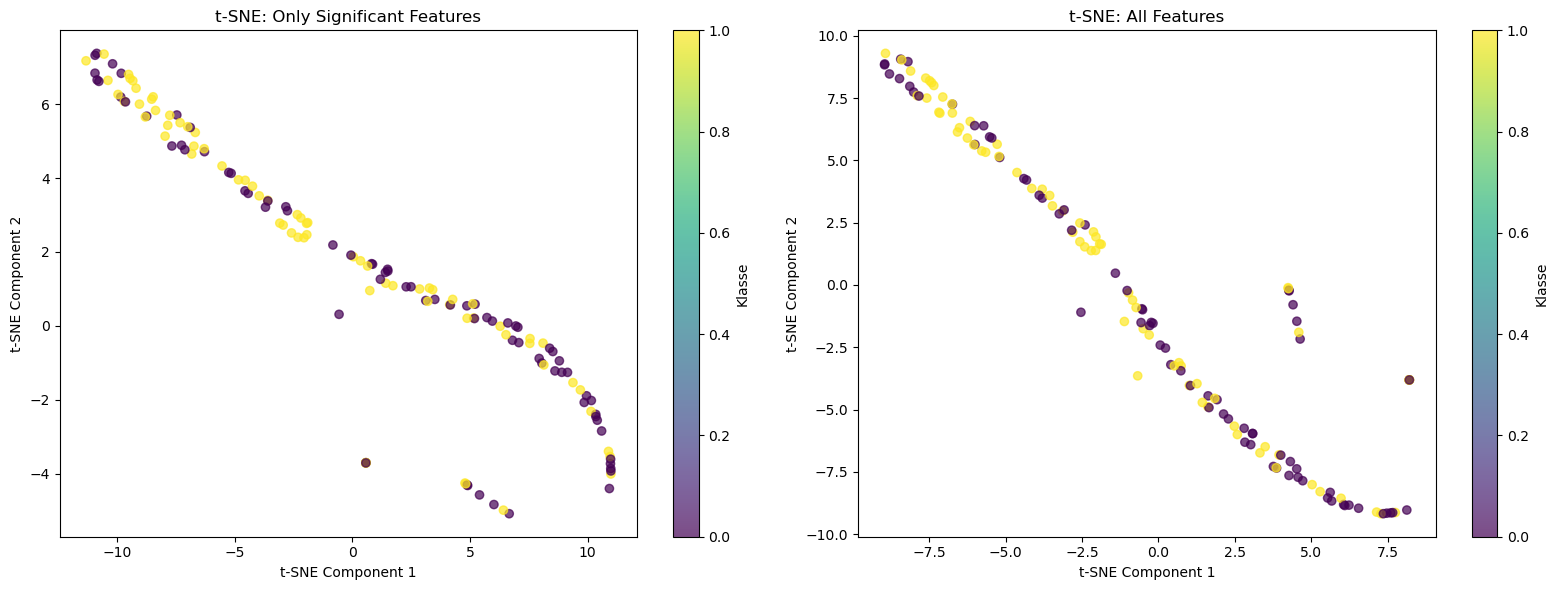

In [ ]:
#plot met t-sne voor dimensie reductie

# t-SNE uitvoeren op de trainingsdata --> x significant 
tsne = TSNE(n_components=2, random_state=42)
x_train_tsne_sig = tsne.fit_transform(x_train_sig)

# t-SNE uitvoeren op de trainingsdata --> x significant 
tsne = TSNE(n_components=2, random_state=42)
x_train_tsne_sig = tsne.fit_transform(x_train_sig)


fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plotten van de t-SNE resultaten
scatter1 = ax[0].scatter(x_train_tsne_sig[:, 0], x_train_tsne_sig[:, 1], c=y_train, cmap='viridis', alpha=0.7)
ax[0].set_title("t-SNE: Only Significant Features")
ax[0].set_xlabel("t-SNE Component 1")
ax[0].set_ylabel("t-SNE Component 2")
fig.colorbar(scatter1, ax=ax[0], label='Klasse')

# t-SNE uitvoeren op de trainingsdata --> alle x ! 
tsne = TSNE(n_components=2, random_state=42)
x_train_tsne = tsne.fit_transform(x_train)

# Plotten van de t-SNE resultaten
scatter2 = ax[1].scatter(x_train_tsne[:, 0], x_train_tsne[:, 1], c=y_train, cmap='viridis', alpha=0.7)
ax[1].set_title("t-SNE: All Features")
ax[1].set_xlabel("t-SNE Component 1")
ax[1].set_ylabel("t-SNE Component 2")
fig.colorbar(scatter2, ax=ax[1], label='Klasse')

plt.tight_layout()
plt.show()

# Linear classifier

In [11]:
# Linear classifier
# Test how many feautures are normal distributed and covariances equal (p > 0.05)

#From features_df, sum how many t test used, i.e. are normal distributed from all features
normal_distributed = features_df.loc[features_df['Test'] == 't-test', 'Test'].count() 
print(f' The ammount of normal distributed features is: {normal_distributed}')

#the ammount of normal distibuted from significant features 
normal_distributed_sig = sig_features_df.loc[features_df['Test'] == 't-test', 'Test'].count() 
normal_distributed_non_sig = normal_distributed - normal_distributed_sig
print(f' The ammount of normal distributed features (p>0.05) {normal_distributed_non_sig}')

#Percentage of usable featrues for lineair classifier
print(f' Percentages of usable features for lineair classifier: {normal_distributed_non_sig/(len(data.columns))*100}')


#hier wordt de lineaire classif gemaakt, bepalen of we dat willen met 52
lda = LinearDiscriminantAnalysis()
lda = lda.fit(x_train, y_train)
y_pred_lda = lda.predict(x_test)


 The ammount of normal distributed features is: 60
 The ammount of normal distributed features (p>0.05) 33
 Percentages of usable features for lineair classifier: 6.680161943319838


# Quadratic classifier

In [12]:
# Quadratic classifier
# Test how many feautures are normal distributed and covariances not equal (p < 0.05)

#From features_df, sum how many t test used, i.e. are normal distributed from all features
normal_distributed = features_df.loc[features_df['Test'] == 't-test', 'Test'].count() 
print(f' The ammount of normal distributed features is: {normal_distributed}')

#the ammount of normal distibuted from non significant features 
normal_distributed_sig = sig_features_df.loc[features_df['Test'] == 't-test', 'Test'].count() 
print(f' The ammount of normal distributed features (p < 0.05) is: {normal_distributed_sig}')

#Percentage of usable featrues for quadratic classifier
print(f' Percentages of usable features for lineair classifier: {normal_distributed_sig/(len(data.columns))*100}')

# quadratic uitvoeren, later wss weg
#q_clas = QuadraticDiscriminantAnalysis()
#q_clas = q_clas.fit(x_train, y_train)
#q_clas_pred = q_clas.predict(x_test)

 The ammount of normal distributed features is: 60
 The ammount of normal distributed features (p < 0.05) is: 27
 Percentages of usable features for lineair classifier: 5.465587044534413


# Voorbeeld functie loss funcite (voor lda) --> niet werkend op lda, code later aanpassen

In [ ]:
#for lda, X1, Y1 in zip(lda, x_train, y_train):
auc=metrics.roc_auc_score(y_train, y_pred_lda)
accuracy=metrics.accuracy_score(y_train, y_pred_lda)
F1=metrics.f1_score(y_train,y_pred_lda)
precision=metrics.precision_score(y_train,y_pred_lda)
recall=metrics.recall_score(y_train, y_pred_lda)

    # accuracy, AUC, f1score, precision, recall
print(type(lda))
print('Acc:' +str(accuracy))
print('AUC:' +str(auc))
print('F1:' +str(F1))
print('precision:' +str(precision))
print('recall:' +str(recall))

for learning_rate in [0.001, 0.01, 0.1, 0.5]:

    print(f"Training with learning rate {learning_rate}")
    print("Training set score: %f" % lda.score(x_train, y_train))
    print("Test set score: %f" % lda.score(x_test, y_test))

    plt.plot(lda.loss_curve_, label=f'lr = {learning_rate}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
plt.legend()
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [148, 38]

# Support vector machine

In [31]:
# Support vector machine ('hard)

pipe = Pipeline([
    ('scaler', RobustScaler()), #robust scaler because of outliners 
    ('svm', LinearSVC(C=100, max_iter=100000))
])

validation_svm_linear = cross_val_score(pipe, x_train, y_train, cv=4)

#svm_linear.fit(x_train, y_train)
#y_train_pred = svm_linear.predict(x_train)
#y_test_pred = svm_linear.predict(x_test)


/usr/local/Caskroom/miniconda/base/envs/machinelearning/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/machinelearning/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/machinelearning/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# Soft margin support vector machine

In [37]:
#sorft margin SVM, search for the best hyperparameters

# Create a pipeline: first scaling, then the SVM classifier
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', SVC())
])

param_distributions = {
    'classifier__C': np.arange(0.001, 1.0, 0.1).tolist(),   
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'classifier__gamma': ['scale', 'auto'],                 # Relevant for rbf, poly, and sigmoid kernels
    'classifier__degree': [2, 3, 4, 5],                     # Only relevant when kernel='poly'
    'classifier__coef0': np.linspace(0, 1, 5).tolist()        # Only relevant for poly and sigmoid kernels
}

# loop over different values for hyperparameters
svm_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=30,       # How many combinations of hyperparameters 
    cv=4,            # 4-fold cross-validation
    scoring='roc_auc',
    random_state=42,
    verbose=1,
    refit=True,
    n_jobs=-1
)

# Execute the Randomized Search on the training data (using only significant features)
svm_search.fit(x_train_sig, y_train)

# Print results
print("Best CV Score:", svm_search.best_score_)
print("Best Estimator:", svm_search.best_estimator_)
print("Best Parameters:", svm_search.best_params_)


#print all restults to check
results_df = pd.DataFrame(svm_search.cv_results_)
#print(results_df[['params', 'mean_test_score', 'std_test_score']])


#analyse op overfitting
print("Best CV Score (ROC):", svm_search.best_score_) #= roc score, geen accuracy

train_score_svm = svm_search.score(x_train_sig, y_train)  #accuracy score op trainingsdata 
print(f"Training score: {train_score_svm}")

validatie_accuracy_svm = cross_val_score(svm_search.best_estimator_, x_train_sig, y_train, scoring='accuracy', cv=4)
print("Accuracy validatie svm:", validatie_accuracy_svm )
print(f'Difference training & validation svm: {train_score_svm-np.mean(validatie_accuracy_svm)}')





Fitting 4 folds for each of 30 candidates, totalling 120 fits


Best CV Score: 0.8340643274853801
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()),
                ('classifier', SVC(C=0.101, kernel='linear'))])
Best Parameters: {'classifier__kernel': 'linear', 'classifier__gamma': 'scale', 'classifier__degree': 3, 'classifier__coef0': 0.0, 'classifier__C': 0.101}
Best CV Score (ROC): 0.8340643274853801
Training score: 0.9793607305936073
Accuracy validatie svm: [0.89189189 0.72972973 0.72972973 0.72972973]
Difference training & validation svm: 0.209090460323337


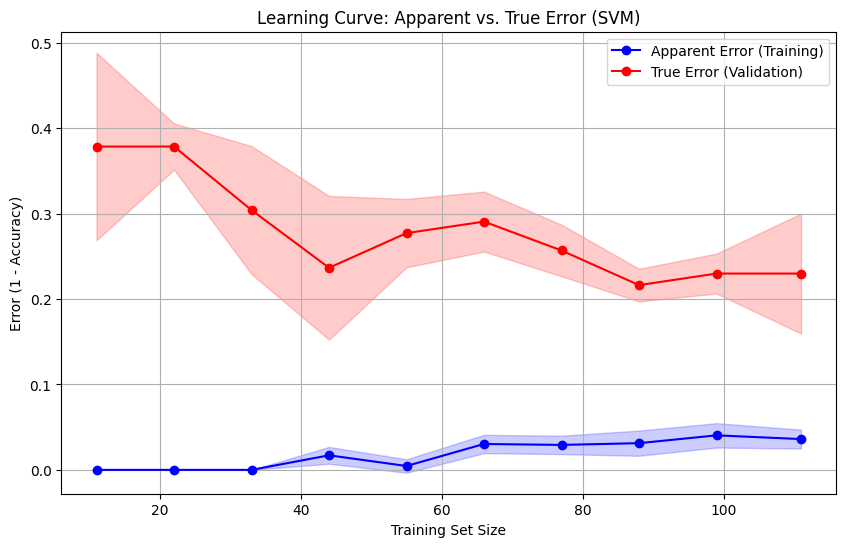

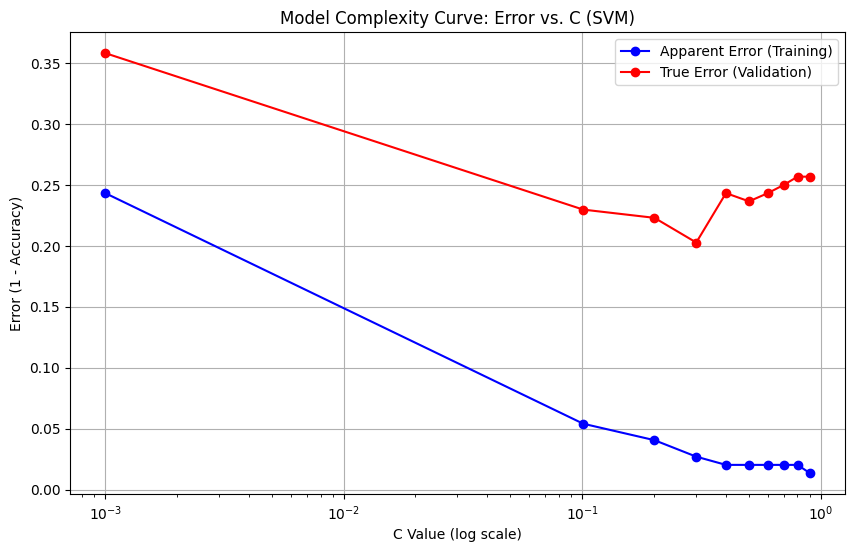

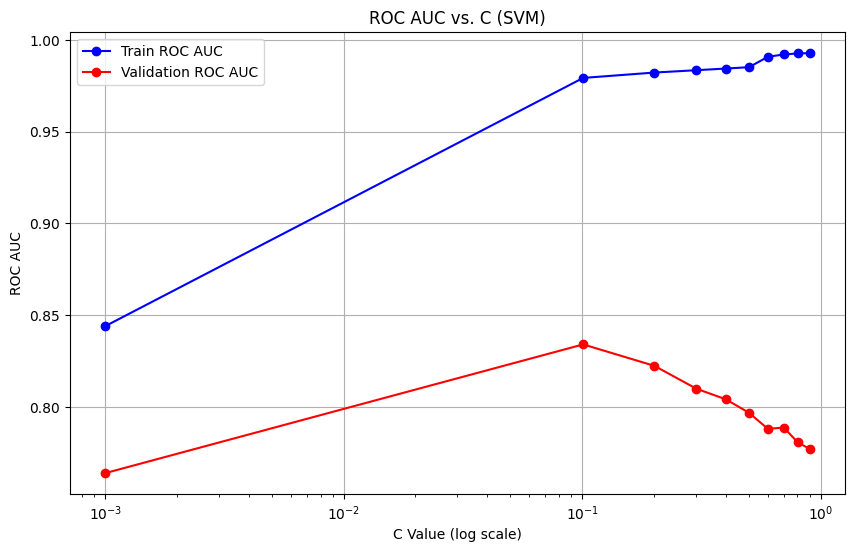

In [38]:
# --- Getting the best parameters from svm_search ---
best_params = svm_search.best_params_
best_C = best_params['classifier__C']
best_kernel = best_params['classifier__kernel']
best_gamma = best_params['classifier__gamma']

if best_kernel == 'poly':
    best_degree = best_params['classifier__degree']
    best_coef0 = best_params['classifier__coef0']
    final_model = SVC(C=best_C, kernel=best_kernel, gamma=best_gamma,
                      degree=best_degree, coef0=best_coef0)
else:
    final_model = SVC(C=best_C, kernel=best_kernel, gamma=best_gamma)

# Building the final pipeline
final_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', final_model)
])

# === PLOT 1: Learning Curve (Apparent vs. True Error) ===
train_sizes, train_scores, val_scores = learning_curve(
    final_pipeline, x_train_sig, y_train, cv=4, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Converting accuracy to the error
train_error = 1 - train_mean
val_error = 1 - val_mean

# Plotting the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_error, marker='o', label='Apparent Error (Training)', color='blue')
plt.plot(train_sizes, val_error, marker='o', label='True Error (Validation)', color='red')
plt.fill_between(train_sizes, train_error - train_std, train_error + train_std, alpha=0.2, color='blue')
plt.fill_between(train_sizes, val_error - val_std, val_error + val_std, alpha=0.2, color='red')
plt.xlabel('Training Set Size')
plt.ylabel('Error (1 - Accuracy)')
plt.title('Learning Curve: Apparent vs. True Error (SVM)')
plt.legend()
plt.grid(True)
plt.show()

# === PLOT 2: Error vs. C ===
C_values = np.arange(0.001, 1.0, 0.1)
train_errors = []
val_errors = []

for C_val in C_values:
    if best_kernel == 'poly':
        model = SVC(C=C_val, kernel=best_kernel, gamma=best_gamma,
                    degree=best_degree, coef0=best_coef0)
    else:
        model = SVC(C=C_val, kernel=best_kernel, gamma=best_gamma)

    pipe = Pipeline([('scaler', RobustScaler()), ('classifier', model)])
    
    # CV Error
    val_accuracy = cross_val_score(pipe, x_train_sig, y_train, cv=4, scoring='accuracy').mean()
    val_errors.append(1 - val_accuracy)

    # Training Error
    pipe.fit(x_train_sig, y_train)
    train_accuracy = accuracy_score(y_train, pipe.predict(x_train_sig))
    train_errors.append(1 - train_accuracy)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(C_values, train_errors, marker='o', linestyle='-', color='blue', label='Apparent Error (Training)')
plt.plot(C_values, val_errors, marker='o', linestyle='-', color='red', label='True Error (Validation)')
plt.xscale('log')
plt.xlabel('C Value (log scale)')
plt.ylabel('Error (1 - Accuracy)')
plt.title('Model Complexity Curve: Error vs. C (SVM)')
plt.legend()
plt.grid(True)
plt.show()

# === PLOT 3: ROC AUC vs. C ===
C_values = np.arange(0.001, 1.0, 0.1)
train_auc_list = []
cv_auc_list = []

for C_val in C_values:
    if best_kernel == 'poly':
        model = SVC(C=C_val, kernel=best_kernel, gamma=best_gamma, degree=best_degree, coef0=best_coef0)
    else:
        model = SVC(C=C_val, kernel=best_kernel, gamma=best_gamma)
    pipe = Pipeline([('scaler', RobustScaler()), ('classifier', model)])
    cv_scores = cross_val_score(pipe, x_train_sig, y_train, cv=4, scoring='roc_auc')
    pipe.fit(x_train_sig, y_train)
    train_auc = roc_auc_score(y_train, pipe.decision_function(x_train_sig))
    train_auc_list.append(train_auc)
    cv_auc_list.append(np.mean(cv_scores))

plt.figure(figsize=(10, 6))
plt.plot(C_values, train_auc_list, marker='o', linestyle='-', label='Train ROC AUC', color='blue')
plt.plot(C_values, cv_auc_list, marker='o', linestyle='-', label='Validation ROC AUC', color='red')
plt.xscale('log')
plt.xlabel('C Value (log scale)')
plt.ylabel('ROC AUC')
plt.title('ROC AUC vs. C (SVM)')
plt.legend()
plt.grid(True)
plt.show()


# Random forest classifier

C:\Users\manon\AppData\Local\Temp\ipykernel_26292\2151526845.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


['PREDICT_original_vf_Frangi_edge_quartile_range_SR(1.0, 10.0)_SS2.0', 'PREDICT_original_vf_Frangi_full_quartile_range_SR(1.0, 10.0)_SS2.0', 'PREDICT_original_vf_Frangi_inner_range_SR(1.0, 10.0)_SS2.0', 'PREDICT_original_vf_Frangi_inner_max_SR(1.0, 10.0)_SS2.0', 'PREDICT_original_vf_Frangi_inner_std_SR(1.0, 10.0)_SS2.0', 'PREDICT_original_vf_Frangi_full_mean_SR(1.0, 10.0)_SS2.0', 'PREDICT_original_vf_Frangi_inner_energy_SR(1.0, 10.0)_SS2.0', 'PREDICT_original_vf_Frangi_full_max_SR(1.0, 10.0)_SS2.0', 'PREDICT_original_vf_Frangi_full_range_SR(1.0, 10.0)_SS2.0', 'PREDICT_original_vf_Frangi_edge_range_SR(1.0, 10.0)_SS2.0', 'PREDICT_original_vf_Frangi_inner_mean_SR(1.0, 10.0)_SS2.0', 'PREDICT_original_vf_Frangi_inner_quartile_range_SR(1.0, 10.0)_SS2.0', 'PREDICT_original_vf_Frangi_full_energy_SR(1.0, 10.0)_SS2.0', 'PREDICT_original_hf_quartile_range', 'PREDICT_original_hf_std', 'PREDICT_original_tf_LBP_std_R3_P12', 'PREDICT_original_logf_quartile_range_sigma5', 'PREDICT_original_logf_kurtos

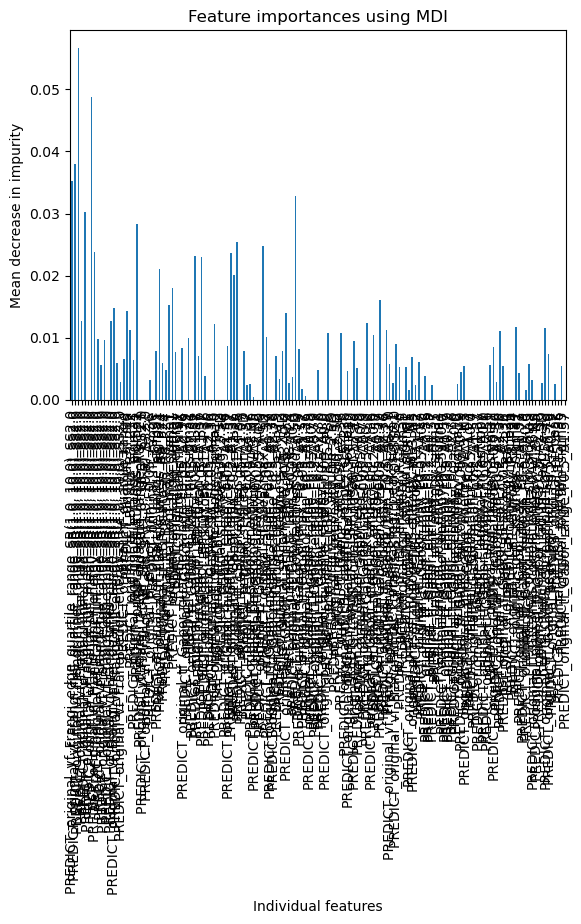

In [ ]:
# random forest code
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance

# Hyperparameter search



# make random forest classifier
rf = RandomForestClassifier(n_estimators=30, criterion='gini', min_samples_split=30)

# fit the classifier to the data
rf.fit(x_train_sig, y_train)
validation_rf = cross_val_score(estimator=rf, X=x_train_sig, y=y_train, cv= 4)
#print(validation_rf)

#plot feature importance, impurity-based

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

feature_names = x_train_sig.columns
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax) #yerr=std
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xlabel("Individual features")
fig.tight_layout()

#make a list with the names of the selected features
selected_feature_names = []
for name, value in zip(feature_names, forest_importances):
    if value > 0.005:
        selected_feature_names.append(name)
print(selected_feature_names)
print(len(selected_feature_names))

# select the data of only the selected features
x_train_sig_selected = x_train_sig[selected_feature_names]

# make classifier
rf2 = RandomForestClassifier(n_estimators=10, criterion='gini', min_samples_split=2)

# fit the classifier to the data with only selected features
rf2.fit(x_train_sig_selected, y_train)
validation_rf2 = cross_val_score(estimator=rf, X=x_train_sig_selected, y=y_train, cv= 4)
print(f'validation rf: {validation_rf}')
print(f'mean score: {np.mean(validation_rf)}')
print(f'validation_rf2: {validation_rf2}')
print(f'mean score: {np.mean(validation_rf2)}')

#analyse op overfitting
train_score_rf = rf.score(x_train_sig, y_train)  #accuracy score op trainingsdata 
print(f"Training score: {train_score}")

print(f'Difference training & validation rf: {train_score_rf-np.mean(validation_rf)}')
print(f'Difference training & validation rf (feature selection): {train_score_rf-np.mean(validation_rf2)}')






# Calculate mean and std of individual classes

In [ ]:
#Decription 
## Dit nog aanpassen naar berekenen op basis van 'label' ipv deze nieuwe csv files
# Mean
benign_mean = benign.mean(numeric_only=True)
malignant_mean = malignant.mean(numeric_only=True)

# Standard deviation
benign_std = benign.std(numeric_only=True)
malignant_std = malignant.std(numeric_only=True)

#Print statistics
benign_stats = pd.DataFrame({
    'mean': benign.mean(numeric_only=True),
    'std': benign.std(numeric_only=True)
})
print(benign_stats)
benign_stats.T.to_csv('benign_stats.csv')


malignant_stats = pd.DataFrame({
    'mean': malignant.mean(numeric_only=True),
    'std': malignant.std(numeric_only=True)
})
malignant_stats.T.to_csv('malignant_stats.csv')

                                                          mean          std
label                                                 1.000000     0.000000
PREDICT_original_sf_compactness_avg_2.5D              0.810147     0.077220
PREDICT_original_sf_compactness_std_2.5D              0.066376     0.050309
PREDICT_original_sf_rad_dist_avg_2.5D                28.506844    12.658553
PREDICT_original_sf_rad_dist_std_2.5D                 4.475117     2.573123
...                                                        ...          ...
PREDICT_original_phasef_phasesym_peak_position_...    0.000000     0.000000
PREDICT_original_phasef_phasesym_range_WL3_N5         0.429725     0.106987
PREDICT_original_phasef_phasesym_energy_WL3_N5      709.573837  1157.150564
PREDICT_original_phasef_phasesym_quartile_range...    0.086281     0.094606
PREDICT_original_phasef_phasesym_entropy_WL3_N5      11.905744     1.959428

[494 rows x 2 columns]


# k-NN Classifier

Best Parameters: {'knn__metric': 'euclidean', 'knn__n_neighbors': 25, 'knn__weights': 'uniform', 'pca__n_components': 5}
Test Accuracy: 0.4737


c:\Users\manon\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\manon\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\manon\miniconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\manon\miniconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "c:\Users\manon\miniconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 90,

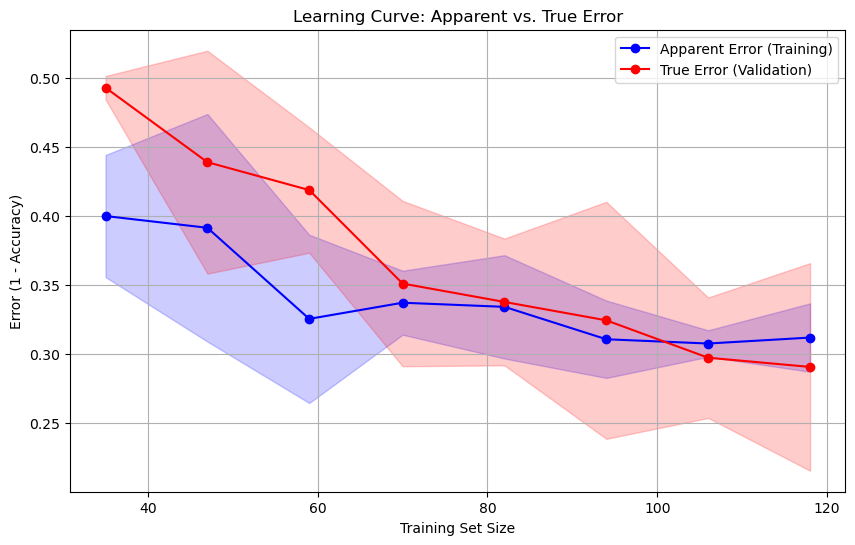

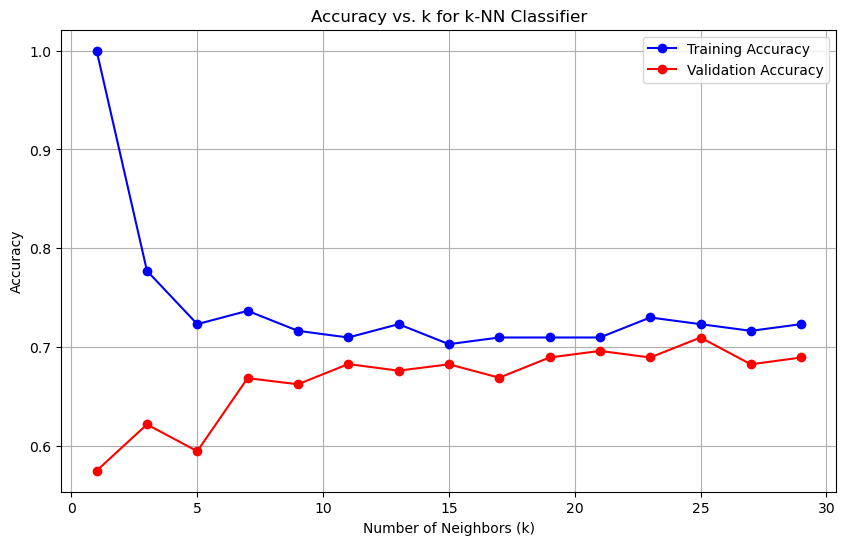

In [16]:
# Making the classifier

# Define the pipeline
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())
])

# Define hyperparameter grid
param_grid = {
    'pca__n_components': [5, 10, 15, 20, 25],
    'knn__n_neighbors': list(range(1, 31, 2)),  # Odd k values from 1 to 29
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}

# Perform hyperparameter optimization
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train, y_train)

# Best model evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred)

# Print best parameters and test accuracy
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Test Accuracy: {test_accuracy:.4f}")

### PLOT 1: Learning Curve (Apparent vs. True Error)
best_k = grid_search.best_params_['knn__n_neighbors']
best_pca = grid_search.best_params_['pca__n_components']

# Define the final best pipeline
pipeline = Pipeline([
    ('scaler', RobustScaler()),  
    ('pca', PCA(n_components=best_pca)),  
    ('knn', KNeighborsClassifier(n_neighbors=best_k, metric='euclidean', weights='uniform'))
])

# Generate learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    pipeline, x_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Compute mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Convert accuracy to error (1 - accuracy)
train_error = 1 - train_mean
val_error = 1 - val_mean

# Plot Apparent Error (Training) vs True Error (Validation)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_error, marker='o', color='blue', label='Apparent Error (Training)')
plt.plot(train_sizes, val_error, marker='o', color='red', label='True Error (Validation)')
plt.fill_between(train_sizes, train_error - train_std, train_error + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, val_error - val_std, val_error + val_std, color='red', alpha=0.2)

# Labels and Title
plt.xlabel('Training Set Size')
plt.ylabel('Error (1 - Accuracy)')
plt.title('Learning Curve: Apparent vs. True Error')
plt.legend()
plt.grid(True)
plt.show()

### PLOT 2: Accuracy vs. k
k_values = list(range(1, 31, 2))  # Odd k values from 1 to 29
train_accuracies = []
val_accuracies = []

# Loop through different k values
for k in k_values:
    # Define the pipeline with current k
    pipeline = Pipeline([
        ('scaler', RobustScaler()),  
        ('pca', PCA(n_components=best_pca)),  
        ('knn', KNeighborsClassifier(n_neighbors=k, metric='euclidean', weights='uniform'))
    ])
    
    # Perform cross-validation
    scores = cross_val_score(pipeline, x_train, y_train, cv=5, scoring='accuracy')
    
    # Fit on training data to get training accuracy
    pipeline.fit(x_train, y_train)
    train_accuracy = accuracy_score(y_train, pipeline.predict(x_train))

    # Store accuracies
    train_accuracies.append(train_accuracy)
    val_accuracies.append(scores.mean())

# Plot training vs validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_accuracies, marker='o', linestyle='-', label='Training Accuracy', color='blue')
plt.plot(k_values, val_accuracies, marker='o', linestyle='-', label='Validation Accuracy', color='red')

# Labels and Title
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. k for k-NN Classifier")
plt.legend()
plt.grid(True)
plt.show()


# Naive Bayes Classifier

Total number of highly correlated feature pairs: 5993


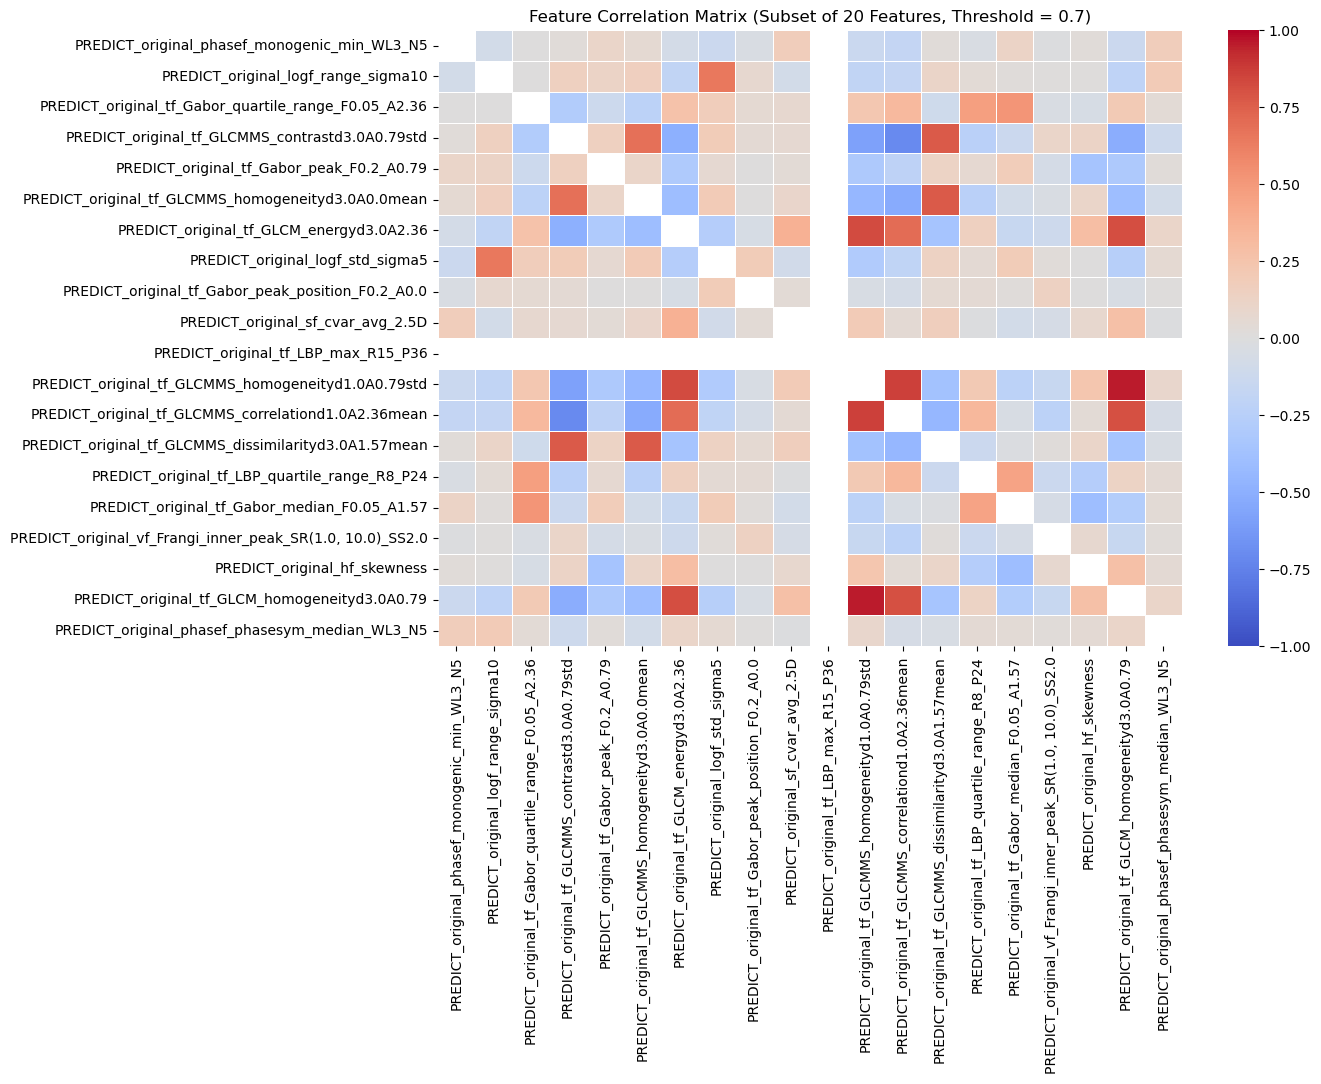

NameError: name 'to_drop' is not defined

In [ ]:
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif

# Computing the correlation matrix of x_train
correlation_matrix = x_train.corr()

# Setting diagonal to NaN so the same features  don't show in the heatmap
np.fill_diagonal(correlation_matrix.values, np.nan)

# Setting the threshold for strong correlation
corr_threshold = 0.7

# Counting the number of highly correlated feature pairs
high_corr_pairs = (correlation_matrix.abs() > corr_threshold).sum().sum() // 2  # Each pair is counted twice
print(f"Total number of highly correlated feature pairs: {high_corr_pairs}")

# Selecting a random subset of 20 features
np.random.seed(42)
sampled_features = np.random.choice(x_train.columns, size=20, replace=False)
correlation_subset = correlation_matrix.loc[sampled_features, sampled_features]

# Plotting the correlation heatmap (subset of features)
plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_subset, 
    cmap="coolwarm", 
    annot=False, 
    linewidths=0.5, 
    vmin=-1, vmax=1  # Fix color range to show small correlations better
)
plt.title(f"Feature Correlation Matrix (Subset of 20 Features, Threshold = {corr_threshold})")
plt.show()


# Loop through each pair and drop one feature
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > corr_threshold:
            colname = correlation_matrix.columns[i]
            to_drop.add(colname)

# Drop the highly correlated features
x_train_reduced = x_train.drop(columns=to_drop)

# Check the number of features remaining
print(f"Number of features remaining: {x_train_reduced.shape[1]}")

In [20]:
# Scoring variables
scoring = ['accuracy', 'roc_auc']

# Cross-validation WSS AL IN CLASSIFIERS ZELF
kn_scores = cross_validate(kn_pipeline, X_train, y_train, cv=5, scoring=scoring)
rf_scores = cross_validate(rf_pipeline, X_train, y_train, cv=5, scoring=scoring)
nb_scores = cross_validate(nb_pipeline, X_train, y_train, cv=5, scoring=scoring)
svm_scores = cross_validate(svm_pipeline, X_train, y_train, cv=5, scoring=scoring)

# Accuracy and roc_auc scores
print("KNN Accuracy scores:", kn_scores['test_accuracy'])
print("KNN ROC AUC scores:", kn_scores['test_roc_auc'])

print("Random Forest Accuracy scores:", rf_scores['test_accuracy'])
print("Random Forest ROC AUC scores:", rf_scores['test_roc_auc'])

print("Naive Bayes Accuracy scores:", nb_scores['test_accuracy'])
print("Naive Bayes ROC AUC scores:", nb_scores['test_roc_auc'])

print("SVM Accuracy scores:", svm_scores['test_accuracy'])
print("SVM ROC AUC scores:", svm_scores['test_roc_auc'])

# Mean accuracy and roc_auc
knn_avg_accuracy = np.mean(kn_scores['test_accuracy'])
knn_avg_roc_auc = np.mean(kn_scores['test_roc_auc'])

rf_avg_accuracy = np.mean(rf_scores['test_accuracy'])
rf_avg_roc_auc = np.mean(rf_scores['test_roc_auc'])

nb_avg_accuracy = np.mean(nb_scores['test_accuracy'])
nb_avg_roc_auc = np.mean(nb_scores['test_roc_auc'])

svm_avg_accuracy = np.mean(svm_scores['test_accuracy'])
svm_avg_roc_auc = np.mean(svm_scores['test_roc_auc'])

# Make directory to compare means
models = {
    'KNN': {'accuracy': knn_avg_accuracy, 'roc_auc': knn_avg_roc_auc},
    'Random Forest': {'accuracy': rf_avg_accuracy, 'roc_auc': rf_avg_roc_auc},
    'Naive Bayes': {'accuracy': nb_avg_accuracy, 'roc_auc': nb_avg_roc_auc},
    'SVM': {'accuracy': svm_avg_accuracy, 'roc_auc': svm_avg_roc_auc}
}

# Search model with highest accuracy and roc_auc
best_accuracy_model = max(models, key=lambda x: models[x]['accuracy'])
best_roc_auc_model = max(models, key=lambda x: models[x]['roc_auc'])

# Print best models
print("\nBeste model op basis van Accuracy:", best_accuracy_model)
print("Beste Accuracy score:", models[best_accuracy_model]['accuracy'])

print("\nBeste model op basis van ROC AUC:", best_roc_auc_model)
print("Beste ROC AUC score:", models[best_roc_auc_model]['roc_auc'])
from sklearn.model_selection import train_test_split

def split_test_data(x, y, random_state, test_size=0.2):
    """
    Splits the data (features x and labels y) into training and testing sets.
    
    Parameters:
    x :             The input feature set (DataFrame).
    y :             The target labels (DataFrame)
    random_state :  The seed used by the random number generator for reproducibility (int).
    test_size :     The proportion of the data to be used as the test set (float, optional (default=0.2)).

    Returns:
    x_train, x_test, y_train, y_test : The training and test splits for both features and labels (arrays).
    """
    # Splitting data into train and test sets based on the specified random state
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, stratify=y, random_state=random_state)
    
    # Printing the shape of the datasets
    print(f"The shapes of the datasets for random_state={random_state} are:")
    print(f"x_train: {x_train.shape}, x_test: {x_test.shape}")
    
    return x_train, x_test, y_train, y_test


## final for loop

y = num_data['label']
x = num_data.drop(columns=['label'])

for i in range(1,6):
    split_test_data(x, y, i, 0.2)


## voorbeeld met kn classifier 

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def split_test_data(x, y, random_state, test_size=0.2):
    """
    Splits the data (features x and labels y) into training and testing sets.
    """
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, stratify=y, random_state=random_state)
    print(f"The shapes of the datasets for random_state={random_state} are:")
    print(f"x_train: {x_train.shape}, x_test: {x_test.shape}")
    return x_train, x_test, y_train, y_test

# Assuming num_data is your dataframe with 'label' column
y = num_data['label']
x = num_data.drop(columns=['label'])

# KNN parameters
k = 5  # Example for the number of neighbors
knn = KNeighborsClassifier(n_neighbors=k)

# Loop through splits and train/evaluate KNN
for i in range(1, 6):
    # Split the data
    x_train, x_test, y_train, y_test = split_test_data(x, y, i, 0.2)
    
    # Fit KNN model
    knn.fit(x_train, y_train)
    
    # Predict and calculate accuracy
    y_pred = knn.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Print the accuracy for this random_state
    print(f"Accuracy for random_state={i}: {accuracy:.4f}\n")


NameError: name 'cross_validate' is not defined